In [ ]:
# download & unzip files (for windows user you have to manually downlad and extract files)
# make sure the extracted folder img_test & img_train contain list of images only

! wget -q https://github.com/CISC-372/Notebook/releases/download/a3/test.zip -O test.zip
! wget -q https://github.com/CISC-372/Notebook/releases/download/a3/train.zip -O train.zip
! wget -q https://github.com/CISC-372/Notebook/releases/download/a3/y_train.csv -O y_train.csv
! unzip -q test.zip
! unzip -q train.zip

In [ ]:
from tqdm import tqdm
from PIL import Image
import pandas as pd
from tqdm.notebook import tqdm
import os
import numpy as np

# Define a function to load the image data stored in the argument folder
# so the input/argument to this load_data function is assumed to be a string of the path of the folder in any directory (if the folder exists in the current directory, only the folder's name is needed to be supplied as a string argumenet to this function)
def load_data(folder):
    images = [] # create an empty list to store the image data
    for file in tqdm(os.listdir(folder)): 
      # os.listdir(folder) will return a string list where each element is the name of one of the objects in the 'folder' (no repetition). The names of the objects in the list are in arbitrary order (so may be different with the order they are stored in the 'folder') 
      # while supplying 'os.listdir(folder)' to 'tqdm()' in the for loop statement is to make the loops showing a smart progress meter (and so you can directly see how well the loop is executing) -> so, in a sense, tqdm() does not do anything but to give the programmer a idea of how the loop is executing
      # so for each of the object names, called 'file', stored in the list returned by 'os.listdir(folder)', we do the following code
        file_id = file.replace('.png', '') # since each training image in the 'folder' is of type 'png', every image object name has a suffix '.png', so this line of code replaces the such suffix with a empty string for each object name in the list gained from 'os.listdir(folder)' -> (namely removing '.png' from each object name in the list) 
        # Note: for this training dataset, each image object name is a integer (in type of string), so the names can be directly used as image id
        image = Image.open( # load the image with the path specified in the argument below
            os.path.join(folder, file) # this is the argument to Image.open(),
            # and 'os.path.join(folder, file)' will return the concatenation of the path of the 'folder' and the current image object name in the current iteration of the loop
            # so 'os.path.join(folder, file)' will give us the path to the current object image in the 'folder'
        ).convert('RGBA').resize((256, 256)) # '.convert('RGBA')' will convert the current image object into 'RGBA' colouring image, so each image will have 4 channels as the 'RGBA' color value is specified by 4 parameters: Red, Green, Blue, and Alpha (for the opacity for a color) 
        # '.resize((256,256))' will resize the current image (with 'RGBA' coloring) into size of 256(width)*256(height) in pixels 
        # so every training image will share the same image size 
        arr = np.array(image) # convert the current image we gained from last line of code into a numpy array with shape (256,256,4), where 4 stands for the 4 channels of 'RGBA' coloring
        images.append(  # append a 2-tuple to the 'images' list, where the first component of the tuple is the current image object name (in type of int) we gained in previous lines of code, and the second component is the numpy array we gained in last line of code  
            (int(file_id), arr) # int(file_id) will convert the image object name of string type into int type 
        ) # end of the for loop
    images.sort(key=lambda i: i[0]) # after the for loop, we sort the 'images' list (with using the lambda function) in a ascending order according to the image object names/id (that have been converted into int type values), which is also the first component of the 2-tuple in the 'images' list
    return np.array([v for _id, v in images]) # [v for _id, v in images] will extract all the numpy arrays of training image objects in the 'images' list (as the numpy arrays of the images are the second component of the 2-tuples in the 'images' list) 
    # namely [v for _id, v in images] will extract all the image numpy arrays from the 'images' list, and integrate those numpy arrays of training images into a single numpy array by 'np.array([v for _id, v in images])', and this is the output of the 'load_data()' function
    # so the output numpy array of 'load_data()' will have shape [None, 256,256,4] as each training image has size 256*256 and 'RGBA' coloring



x_train = load_data('train')  # load the training image data with using the load_data function defined above, and we supply 'train' to 'load_data()', because the training images are stored in a folder called 'train' in the current directory 
y_train = pd.read_csv('y_train.csv')['infection'] # load the training class labels by reading the whole 'y_train.csv' file first, and then selecting the column 'infection' in the 'y_train.csv' file only (as 'infection' is the target attribute)

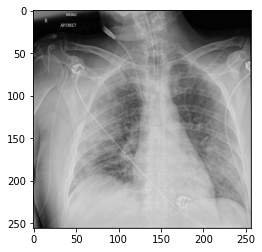

In [ ]:

# check image loading
import matplotlib.pyplot as plt
plt.imshow(x_train[5]) # the function 'plt.imshow()' will display the input argument data as an image, so it accepts the input argument as being actual RGB(A) data that can be rendered as a pseudocolor image (which is the element/tensor in the 'x_train' numpy array)  

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, Input

def build():        #comment the shape of the output of each layer.
    img_in = Input(shape=(256, 256, 4)) # Input() is used to instantiate a Keras tensor with shape specified in the parameter 'shape', 
    # in this case, the 'shape=(256, 256, 4)' indicates that the expected input will be a tensor with size [256,256,4], which is exactly the training image size
    flattened = Flatten()(img_in) # flattens the input tensor out. In this case, it transform a tensor with size [256,256,4] into a vector with the number of entries being 256*256*4 = 262144  
    # so the output shape of this layer is: 256*256*4 = 262144, as we simply did a flatten operation here 

    # change the hidden units to 256,   
    fc1 = Dense(256)(flattened) # build a Dense layer with 256 hidden units in it, no activation function
    #fc1 = Dropout(0.3)(fc1) # this is the Dropout layer that randomly sets input units to 0 with a frequency of 30% at each step during training time, which helps prevent overfitting.
  
  # add one more intermediate layer fca1 with 128 hidden units 
    fca1 = Dense(1024,activation='relu')(fc1) # try activation function = 'tanh'

  # add one more intermediate layer fca2 with 128 hidden units, 
    fca2 = Dense(256)(fca1)

    # change the hidden units in this layer to 64, with an 'relu' activation function
    fc2 = Dense(64, activation='relu')(fca2)
    #fc2 = Dropout(0.3)(fc2)

    output = Dense(1, activation = 'sigmoid')(fc2)
    model = tf.keras.Model(inputs=img_in, outputs=output)
    return model


model = build()
model.compile(
        optimizer= tf.keras.optimizers.Adadelta(), 
        #tf.keras.optimizers.SGD(learning_rate=0.001,nesterov=False), #tf.keras.optimizers.Adadelta(), 
        # try different optimizer tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 4)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               67109120  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65    

In [ ]:

epochs = 50
batch_size = 488 # try 488 instead of 64 

history = model.fit(x = x_train,
                    y = y_train,
                    batch_size = batch_size,
                    validation_split=0.3, #initial value is .3
                    epochs=epochs
                    )

# tuning log:
# 1st tuning: Change batch_size to 488 (only has 487 samples), validation_split=.2 to give more training samples, added one intermediate layer with 256 hidden units with activation='relu', change hidden units of fc1 to 128, fc2 to 64, and give fc1 activation function 'relu'
# result: some validation auc are 70%, while the other are only 47%, might because the validation set is small, so the variance of validation auc is high, 

# 2nd tuning: remove activation function for fc1, change validation_split back to 30%, change epochs=50 to ensure reaching the good enough local minima or global minima, add one more intermediate layer fca2 with 128 hidden units, activation function for the last second layer fc2 is set to be 'tanh', change the hidden units of fc1 to 256, fca1 to 1024, fca2 to 256
# result: both training and validation auc are stablized around 50%, try to change the optimizer to 'AdaDelta'

# 3rd tuning: Shift optimizer to 'AdaDelta', change hidden unit in fca2 to 256
# result: the validation auc is varying within the range of 45% to 65%, which indicates that changing the optimizer has a certain degree of improvement on the model performance

# 4th tuning: Shift optimizer to 'SGD with momentum', change hidden units in the first layer fc1 to 512
# result: the validation auc is stablized around 50%, but training speed decreases as the number of parameters in the first layer is very high, 

# 5th tuning: Add activation function 'relu' to first layer fc1, and remove the activation function in the second layer fca1
# result: both training and validation auc are stablized around 50%, so providing activation function to the first layer can significantly reduce the variacne of the auc

# 6th tuning: turn on the Nesterov momentum in the optimizer 'SGD with momentum', 
# result: both training and validation auc are still stablized around 50%, training speed did not improve

# 7th tuning: set learning_rate of optimizer to 0.001
# result: both training and validation auc are still stablized around 50% (with some exceptions reaching 65% or 43%), meaning that setting activation function for the first layer can reduce the variacne of the auc. 
# Highlight of result: both of the training and validation auc around 50% means that the prediction is not better than random guessing (since the Kaggle leaderboard is using 'auc' as the evaluation metric, we tends to get a score around '50%'), so we have to adjust the model or change to another model architecture
# result on Leaderboard: as we expected, we get a score of 51% in the Kaggle public leaderboard

# 8th tuning: remove activation function for first layer, set the activation function for second layer fac1 to 'relu', turn off Nesterov momentum in 'SGD with momentum' 
# result: disregarding of the accuracy, both of the training and validation auc are stabilized at 49% (sligh decrease in model performance)

# 9th tuning: Shift the optimizer back to 'Adam', change the hidden units in first layer to 256, change the activation function of the last second layer fc2 to be 'relu'
# result: both of the training and validation auc are stabilized at 50% (with some reaching 58%). 

# 10th tuning: change the optimizer to 'AdaDelta'
# result: Bboth of the training and validation auc are stabilized at 50% (with some reaching 59%). This is showing that no matter how we tune the fully-connected NN for this problem, the upper limit of this model is around 60% in auc, which is not satisfactory, and we should try to use a better model architecture such as Conv2D to solve the problem
# Highlight of the result: For this problem, 'AdaDelta' performs slightly better than 'Adam' and 'SGD with momentum' regarding the validation auc (as 'AdaDelta' can sometimes produce auc around 60%, while the other 2 optimizers stabilize the validation auc at 50%)




Epoch 1/50
1/1 [==============================] - 1s 952ms/step - loss: 102.6500 - binary_accuracy: 0.6765 - auc: 0.5000 - val_loss: 13.2251 - val_binary_accuracy: 0.3537 - val_auc: 0.4284
Epoch 2/50
1/1 [==============================] - 0s 137ms/step - loss: 13.5261 - binary_accuracy: 0.3676 - auc: 0.4975 - val_loss: 106.1952 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 134ms/step - loss: 100.2276 - binary_accuracy: 0.6765 - auc: 0.5000 - val_loss: 29.7071 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 132ms/step - loss: 27.9419 - binary_accuracy: 0.6765 - auc: 0.5000 - val_loss: 68.0112 - val_binary_accuracy: 0.3469 - val_auc: 0.5052
Epoch 5/50
1/1 [==============================] - 0s 131ms/step - loss: 69.6900 - binary_accuracy: 0.3235 - auc: 0.5000 - val_loss: 64.4371 - val_binary_accuracy: 0.6531 - val_auc: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 122m

In [ ]:
x_test = load_data('test')
y_test = model.predict(x_test)

y_test_df = pd.DataFrame()
y_test_df['id'] = np.arange(len(y_test))
y_test_df['infection'] = y_test.astype(float)
y_test_df.to_csv('submission.csv', index=False)

## Train a Conv2D model

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

# Creates the Conv2D model

conv_model = Sequential()
conv_model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, use_bias=False, input_shape=(128, 64, 5))) # Use 128 kernels with window size 3*3, activate the padding, 
# specifiying the input sample shape (256,256,4) at the first layer of the CNN model is necessary, because the model does not know the shape of the input per sample

conv_model.add(Conv2D(93, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation=None))

conv_model.add(MaxPool2D(pool_size=(2, 2))) # summarize the output from the last conv2d
# note: the conv2d layer and the pooling layer are usually used at the same time (like a combo)
 
#conv_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same')) # added one layer in 20th tuning
#conv_model.add(MaxPool2D(pool_size=(2, 2)))
#conv_model.add(Dropout(0.1))  # add a dropout layer to avoid overfitting 

conv_model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
conv_model.add(MaxPool2D(pool_size=(2, 2))) #AveragePooling2D(pool_size=(2,2)))   # add first pooling layer to halve the image dimension

#conv_model.add(Dropout(0.2)) # add a dropout layer to avoid overfitting 

#conv_model.add(Conv2D(512,kernel_size=(3, 3), activation='relu',)) # this is the conv2d layer added in the 12th tuning
#conv_model.add(MaxPool2D(pool_size=(2, 2))) # pooling layer added in the 13th tuning
conv_model.add(Conv2D(1024,kernel_size=(3, 3), activation='relu',padding='same'))

conv_model.add(MaxPool2D(pool_size=(2, 2))) #AveragePooling2D(pool_size=(2,2))) # another pooling layer with using the max pooling function
conv_model.add(Conv2D(256,kernel_size=(3, 3),activation='relu',padding='same')) # the last conv2d layer
conv_model.add(MaxPool2D(pool_size=(2, 2)))
conv_model.add(Flatten()) # flatten out the output of the last pooling layer
#conv_model.add(Dense(128, activation='relu')) # added layer in 4th tuning
conv_model.add(Dense(64, activation='relu')) # shift to the fully-connected NN to do the prediction
conv_model.add(Dense(1, activation='sigmoid')) # output layer of the Conv2d model



conv_model.compile(
        # try different optimizer
        optimizer= tf.keras.optimizers.Adadelta(),#tf.keras.optimizers.Adam(),
        # tf.keras.optimizers.RMSprop(),
        #tf.keras.optimizers.SGD(nesterov=False), #tf.keras.optimizers.Adadelta(), 
       
        loss='binary_crossentropy',
        metrics=['BinaryAccuracy', 'AUC']
        )


conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 64, 128)      5760      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 126, 62, 93)       107229    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 31, 93)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 63, 31, 512)       429056    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 15, 512)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 15, 1024)      4719616   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 7, 1024)      

In [ ]:
from sklearn.utils import shuffle
epochs = 100
batch_size = 16

x, y = shuffle(x_train, y_train) # shuffle x_train and y_train here

# use Callback() method to save the Keras model or the model weights that yield the highest validation auc
checkpoint_filepath = '/checkpoint' # set the path to save the check_point model parameters
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( # define the Callback() function
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc', # we can try switch 'val_auc' with 'val_binary_accuracy' as usually high validation binary accuracy comes along with high validation auc
    mode='max',
    save_best_only=True)

history = conv_model.fit(x = x,
                    y = y,
                    batch_size = batch_size,
                    validation_split=0.3, #initial value is .3
                    epochs=epochs,
                    callbacks=[model_checkpoint_callback] # implement Callback() in conjunction with '.fit()' to save a model or weights (in a checkpoint file) that yield the highest validation auc score
                    )
# put/load the weights into the convolutional model
conv_model.load_weights(checkpoint_filepath)

# Adjustment log:
# Initial design of the Conv2D: first layer (64 filters, kernel_size=3, padding='same', no activation function), second layer(128 filters, 'relu' activation), third layer (average pooling layer), fourth layer (256 filters, no activation), fifth layer (average pooling layer), sixth layer (128 filters, no activation), seventh layer (flatten layer), eighth layer (dense layer with 64 hidden units, 'relu' activation), final layer (dense layer with 1 hidden unit, 'sigmoid' activation)
# optimizer = adam, batch size = 32 (as the batch_size of 488 will caucse 'overflow') 
# initial result: validation auc is varying within the range of 50% to 65%, which slightly outperforms the fully-connected NN we trained in the previous cells of code

# 1st tuning: change batch size to 64, turn off the padding for the first layer, change all the pooling layers from using average pooling function to using the max pooling function
# result: validation auc is still varying within the range of 50% to 70%, which may means that the 'max' pooling layer function may outperforms the 'average' pooling layer function 
# result on Leaderboard: we get a score of 70.7% in the Kaggle public leaderboard

# 2nd tuning: change the optimizer from 'Adam' to 'AdaDelta', add activation function 'relu' to all the Conv2D layers
# result: validation auc is still varying within the range of 50% to 70%, which may means the performance between 'Adam' and 'AdaDelta' optimizer for this model is not considerable

# 3rd tuning: Remove the activation function for the first layer, change filter in second layer to 256, change filter in fourth layer to 512, change batch size to 32 (avoid overflow)
# result: validation auc is varying within the range of 50% to 75%, which is an improvement on the performance of the Conv2D model, though the training time increases significantly (so increasing filter numbers can improve the auc linearly)
# result on Leaderboard: we get a score of 73.6% in the Kaggle public leaderboard

# 4th tuning: change the last second layer to have 128 hidden units, add one Dense layer before the final layer with 64 hidden units and activation function 'relu', to see if the Dense layer would improve the model 
# result: validation auc is varying within the range of 30% to 75%, which means the Dense layer can affect the variance of the validation auc but not decreasing the bias

# 5th tuning: remove the added Dense layer we added in the last tuning, increase the number of hidden units in the second last Dense layer to 128, change the optimizer to 'SGD' 
# result: validation auc is stabilized exactly at 50%, which indicates that the optimizer 'SGD' tends to be trapped at certain local minima that are not feasible

# 6th tuning: change the optimizer to 'Adam'
# result: validation auc is stabilized exactly at 50%, which indicates that the optimizer 'Adam' tends to also be trapped at certain local minima that are not feasible

# 7th tuning: change the optimizer to 'AdaDelta' to do comparison
# result: validation auc is varying within the range of 55% to 75%
# Highlight of the result: For this model, the optimizer 'AdaDelta' outperforms 'SGD' and 'Adam' significantly as both 'SGD' and 'Adam' only yield auc at 50%, which is not better random guessing

# 8th tuning: change the number of hidden units in the second last Dense layer to 64, change the the number of filters in the first layer to 128, change all Con2D layer window size to (2,2)
# result: validation auc is varying within the range of 45% to 73%, performance decreases silghtly, might because of the window size chosen and the number of filters in the first layer

# 9th tuning: change the the number of filters in the first layer to 40
# result: validation auc is still varying within the range of 45% to 73%, which might indicate that decreasing the Kernel/window size may not improve the model's performance

# 10th tuning: change all Conv2D layer window size to (3,3), change the the number of filters in the second Conv2D layer to 512, change the the number of filters in the third Conv2D layer to 1024, change the the number of filters in the fourth Conv2D layer to 256, to see if continuously increasing the filters will improve the model performance or if we need to add an additional layer
# result: training auc is varying within the range of 50% to 95%, while the validation auc is still varying within the range of 45% to 75%, so no improvement on the model performance, may try to add extra Conv2D layer and reduce the current filters, training time increase
# Highlight of result: Increasing the 'kernel_size' continuously will lead to overfitting

# 11th tuning: change the number of filters in the second Conv2D layer to 64, add a Max pooling layer after the first Conv2d layer, change batch_size to 16 (avoid 'overflow'),
# result: validation auc is varying within the range of 47% to 80%, which is an improvement on the model performance, indicating that a pooling layer between every 2 Conv2d layers is a good model design
# result on Leaderboard: we get a score of 74.2% in the Kaggle public leaderboard

# 12th tuning: add one more conv2d layer with 512 filters before the third conv2d layer, and change the number of filter in the third conv2d layer from 1024 to 512 , to see if spliting the filters in different layers could improve model performance 
# result: validation auc is varying within the range of 47% to 79%, slight decrease in model performance, which means that adding more layers might not help to improve the model performance further

# 13th tuning: add a max pooling layer between the third and the fourth conv2d layer
# result: validation auc is varying within the range of 47% to 65%, huge decrease in model performance, which means the extra layers should be better removed

# 14th tuning: remove the third conv2d layer and pooling layer, change the number of filter in the current third conv2d layer from 512 to 1024, set padding='same' for all the conv2d layers except the first one to see if padding can improve performance 
# result: validation auc is varying within the range of 47% to 77%, which may indicates that padding should not be used in this problem as it did not improve model's performance

# 15th tuning: change the number of filter in the fourth conv2d layer from 256 to 512
# result: validation auc is still varying within the range of 47% to 77%

# 16th tuning: change the number of filter in the fourth conv2d layer from 512 to 256, shift optimizer from 'AdaDelta' to 'Adam'
# result: validation auc is varying within the range of 45% to 73% , meaning that 'AdaDelta' still outperforms 'Adam'

# 17th tuning: change optimizer from 'Adam' to 'RMSprop'
# result: validation auc is stabilized exactly at 50%, which indicates that the optimizer 'RMSprop' tends to also be trapped at certain local minima that are not feasible

# 18th tuning: change optimizer from 'RMSprop' to 'AdaDelta', set the kernel_size=4 for all the conv2d layers to see if expanding the window size can improve model performance
# result: validaton acu is stabilized around 77% (with some exceptions being about 55%), improvement on the model performance
# result on Leaderboard: we get a score of 77.0% in the Kaggle public leaderboard

# 19th tuning: change all kernel_size back to 3, change the strides in the first conv2d layer to (2,2), 
# result: validaton acu is varying within the range of 56% to 77%, no improvement on the model performance, which might indicates that tuning strides might not affect the model performance much

# 20th tuning: add one conv2d layer with 256 filters after the first conv2d layer, then add 2 Dropout layers above (with rate=0.1) and below (with rate=0.2) this new added conv2d layer to see if Dropout can prevent overfitting
# result: validaton acu is varying within the range of 49% to 70%, which is a deterioration on the model performance
# Highlight of result: The reason why the Dropout layer failed to work may because that the number of training samples we have is quite small (around 500 only), and so dropping certain images may lead to a failure of capturing the underlying patterns within the training dataset. 

# 21th tuning: change epoch to 100, add check_point function, remove the dropout layers, added one Max pooling layer before the flatten layer
# result: validaton acu is varying within the range of 50% to 88%


Epoch 1/100
22/22 [==============================] - 10s 350ms/step - loss: 1.1749 - binary_accuracy: 0.5673 - auc: 0.4856 - val_loss: 1.1623 - val_binary_accuracy: 0.4014 - val_auc: 0.5676
Epoch 2/100
22/22 [==============================] - 7s 300ms/step - loss: 0.8492 - binary_accuracy: 0.5948 - auc: 0.5064 - val_loss: 1.0387 - val_binary_accuracy: 0.4354 - val_auc: 0.6227
Epoch 3/100
22/22 [==============================] - 7s 302ms/step - loss: 0.7155 - binary_accuracy: 0.6402 - auc: 0.6513 - val_loss: 1.3586 - val_binary_accuracy: 0.6259 - val_auc: 0.6796
Epoch 4/100
22/22 [==============================] - 7s 305ms/step - loss: 0.7151 - binary_accuracy: 0.6850 - auc: 0.6740 - val_loss: 0.7465 - val_binary_accuracy: 0.6599 - val_auc: 0.7128
Epoch 5/100
22/22 [==============================] - 7s 304ms/step - loss: 0.5908 - binary_accuracy: 0.6822 - auc: 0.7350 - val_loss: 0.5873 - val_binary_accuracy: 0.7483 - val_auc: 0.7353
Epoch 6/100
22/22 [==============================] - 7

In [ ]:
# apply the trained model to the testing set, and create the submission csv file to the Kaggle Leaderboard
x_test = load_data('test')
y_test = conv_model.predict(x_test)

y_test_df = pd.DataFrame()
y_test_df['id'] = np.arange(len(y_test))
y_test_df['infection'] = y_test.astype(float)
y_test_df.to_csv('submission.csv', index=False)

In [ ]:
!sudo apt-get install texlive-xetex
!jupyter nbconvert --to pdf a3_original_template_pdf.ipynb